In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

In [2]:
# data
file_taxi_january = 'yellow_tripdata_2023-01.parquet'
file_taxi_february = 'yellow_tripdata_2023-02.parquet'

# 2021 (used in the video examples)
file_green_january = 'green_tripdata_2021-01.parquet'
file_green_february = 'green_tripdata_2021-02.parquet'

In [3]:
def check_percentiles_df(df, column='duration_minutes'):
    """ Quickly see the extreme percentiles of a feature """    

    # upper values
    with pd.option_context('display.float_format', '{:.0f}'.format):
        print(df[column].describe(percentiles=[0.95, 0.98, 0.99, 0.998]))

    # lowest values
    with pd.option_context('display.float_format', '{:.0f}'.format):
        print(df[column].describe(percentiles=[0.01, 0.05, 0.1]))

In [4]:
def read_dataframe(filename: str, type) -> pd.DataFrame:
    # create a dataframe
    if type=="parquet":
        df = pd.read_parquet(filename, engine='pyarrow')
    if type=="csv":
        df = pd.read_csv(filename)
    # take a look
    print(f"Input Dataframe shape: {df.shape}")
    
    #df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    # Create a new column that represents the trip duration in minutes instead of data_time objs
    df['duration_minutes'] = df.duration.apply(lambda x: x.total_seconds() / 60)
    print(f"Filtered Dataframe shape: {df.shape}")

    # PULOcation = Pickup Location ID, DOLocation = Drop-off location ID
    categorical = ['PULocationID', 'DOLocationID']
    # cast to String type
    df[categorical] = df[categorical].astype(str)
        
    return df
    
    # visualize the distribution of trips duration
    #sns.histplot(df.duration_minutes)
    sns.distplot(df.duration_minutes)
    

In [5]:
def log_scale_feature(df, column='duration_minutes'):
    """ Changes a given column into its logarithmic scale
     It will create a new column with the prefix 'log_' added to the transformed column name
      Returns: a dataframe with the new column added. """    

    # test logaritmic scale
    new_column_name = 'log_' + column

    df[new_column_name] = np.log(df[column] + 1)  # Add 1 to avoid log(0) issues
    sns.distplot(df[new_column_name])
    return df


In [6]:
# create dataframes for the ML model
df_train = read_dataframe(filename=file_green_january, type='parquet')
df_val = read_dataframe(filename=file_green_february, type='parquet')

Input Dataframe shape: (76518, 20)
Filtered Dataframe shape: (76518, 22)
Input Dataframe shape: (64572, 20)
Filtered Dataframe shape: (64572, 22)


In [7]:
check_percentiles_df(df_train)
print("- - - - - - - - - -")
check_percentiles_df(df_val)

count   76518
mean       20
std        59
min         0
50%        14
95%        44
98%        56
99%        67
99.8%     368
max      1440
Name: duration_minutes, dtype: float64
count   76518
mean       20
std        59
min         0
1%          0
5%          3
10%         5
50%        14
max      1440
Name: duration_minutes, dtype: float64
- - - - - - - - - -
count   64572
mean       21
std        53
min         0
50%        15
95%        49
98%        63
99%        75
99.8%     309
max      1440
Name: duration_minutes, dtype: float64
count   64572
mean       21
std        53
min         0
1%          0
5%          3
10%         5
50%        15
max      1440
Name: duration_minutes, dtype: float64


Train dataset


/tmp/ipykernel_132643/2006858150.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration_minutes)


<Axes: xlabel='duration_minutes', ylabel='Density'>

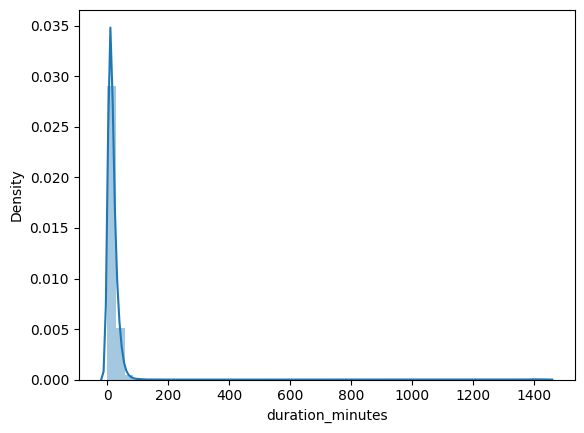

In [8]:
# visualize the new distribution
print("Train dataset")
sns.distplot(df_train.duration_minutes)

Validation dataset


/tmp/ipykernel_132643/3090966874.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val.duration_minutes)


<Axes: xlabel='duration_minutes', ylabel='Density'>

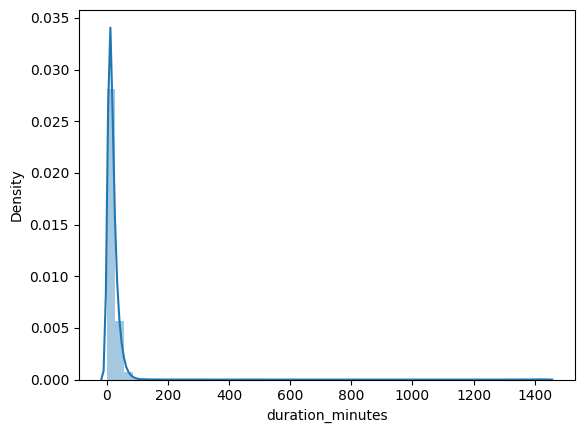

In [9]:
print("Validation dataset")
sns.distplot(df_val.duration_minutes)

In [10]:
# Import DictVectorizer to do one-hot encoding to our categorical variables later
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

numerical = ['trip_distance']

In [11]:
# Turn the DF into dictionary
def create_dict_vect(df, numerical):
        

    train_dicts = df[categorical + numerical] \
        .to_dict(orient='records')

# Create data to train the model
    dv = DictVectorizer()

    X_train = dv.fit_transform(train_dicts)

    # Preview
    print(len(dv.feature_names_))
    dv.feature_names_[:5]

    # Target variable (prediction)
    target = 'duration_minutes'
    # target = 'log_duration_minutes'
    y_train = df2[target].values

    # train the model
    lr = LinearRegression()

    lr.fit(X_train, y_train)

    # predict
    y_pred = lr.predict(X_train)

    # Visualize predictions against actual values


    y_pred_minutes = np.exp(y_pred) - 1  # Convert back to minutes

    sns.distplot(y_pred, label='Prediction')
    sns.distplot(y_train, label='Actual data')

    plt.legend()

    # Error metrics
    print(f'Mean Squared Error: {mean_squared_error(y_train, y_pred, squared=False)}')

    # view how many NA values are in the DF
    print('Null values in the complete dataframe')
    df.isna().sum()


In [12]:
def predict_lasso(x, y):

    # Lasso
    # train the model
    lr = Lasso()

    lr.fit(X_train, y_train)
    # predict
    y_pred = lr.predict(X_train)

    # Visualize predictions against actual values


    y_pred_minutes = np.exp(y_pred) - 1  # Convert back to minutes

    sns.distplot(y_pred, label='Prediction')
    sns.distplot(y_train, label='Actual data')

    plt.legend()
    # Error metrics
    mean_squared_error(y_train, y_pred, squared=False)
